In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r "/content/drive/My Drive/NLP/assignment1/." "./"

In [2]:
# !pip install -r requirements.txt

In [3]:
%load_ext autoreload
%autoreload 2

In [30]:
import re
import os
import functools
import random
import itertools
from typing import List, Callable, Dict, Iterable, Tuple, Set, Optional, Literal
from collections import OrderedDict
from enum import Flag, auto

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import keras as ks
import keras.backend as K
import keras_tuner

import gensim
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

import config
from config import *
from util import *
from embedding import *
from preprocessing import *

set_reproducibility(42)

In [5]:
print(get_variables('config'))

{}


## 1. Dataset Loading

In [6]:
def read_tagged_sentences(filename: str) -> List[str]:
    with open(filename, mode='r', encoding='utf-8') as text_file:  
        corpus = text_file.read()
        return corpus.split("\n\n")

def get_tagged_words(tagged_sentence: str) -> List[str]:
    return tagged_sentence.rstrip('\n').split("\n")

def split_words_and_tags(tagged_words: List[str]) -> Tuple[List[str], List[str]]:
    words = []
    tags = []
    for tagged_word in tagged_words:
        word, tag = split_word_and_tag(tagged_word)
        words.append(word)
        tags.append(tag)
    return words, tags

def split_word_and_tag(tagged_word: str) -> Tuple[str, str]:
    entity = tagged_word.split("\t")
    # (word, tag)
    return entity[0], entity[1]

def read_data(filename) -> Tuple[List[str], List[str]]:
    tagged_sentences = read_tagged_sentences(filename)
    
    sentences: List[str] = []
    labels: List[str] = []
    for tagged_sentence in tagged_sentences:
        tagged_words = get_tagged_words(tagged_sentence)
        words, tags = split_words_and_tags(tagged_words)
        sentences.append(words_separator.join(words))
        labels.append(words_separator.join(tags))

    assert len(sentences) == len(tagged_sentences)
    assert len(labels) == len(tagged_sentences)

    return sentences, labels

def create_dataset(dataset_name="dependency_treebank", train_split=100, validation_split=150, test_split=199):
    def file_id_to_split(file_id: int):
        assert file_id <= test_split

        if file_id <= train_split:
            return 'train'
        if file_id <= validation_split:
            return 'validation'
        
        return 'test'

    dataset_folder = os.path.join(os.getcwd(), dataset_name)
    file_ids = []
    sentences = []
    labels = []
    for file_id in tqdm(range(1, test_split+1)):
        filename = os.path.join(dataset_folder, "wsj_%04d.dp" % file_id)
        sentences_, labels_ = read_data(filename)
        sentences += sentences_
        labels += labels_
        file_ids += [file_id] * len(sentences_)
         
    df = pd.DataFrame({'sentence': sentences, 'pos': labels, 'file_id': file_ids})
    df['split'] = df['file_id'].apply(file_id_to_split)
    
    df.to_pickle(os.path.join(dataset_folder, dataset_name + ".pkl"))
    df.to_json(os.path.join(dataset_folder, dataset_name + ".json"))
    return df

print("Creating dataset...")
df = create_dataset(dataset_name=dataset_name)
print("Creation completed!")

df

Creating dataset...


100%|██████████| 199/199 [00:00<00:00, 4269.07it/s]

Creation completed!


,sentence,pos,file_id,split
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ...",1,train
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN .",1,train
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN...",2,train
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...,3,train
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ...",3,train
...,...,...,...,...
3909,They also said that more than a dozen presiden...,PRP RB VBD IN JJR IN DT NN NNS VBP VBN IN JJ N...,198,test
3910,Sen. Kennedy said in a separate statement that...,NNP NNP VBD IN DT JJ NN IN PRP VBZ NN TO VB DT...,198,test
3911,Trinity Industries Inc. said it reached a prel...,NNP NNPS NNP VBD PRP VBD DT JJ NN TO VB CD NN ...,199,test
3912,Terms were n't disclosed .,NNS VBD RB VBN .,199,test


In [7]:
train_data, val_data, test_data = split_dataset(df)
print('Dataset splits statistics: ')
print(f'Train data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Test data: {test_data.shape}')

Dataset splits statistics: 
Train data: (1963, 4)
Validation data: (1299, 4)
Test data: (652, 4)


# 2. Data Exploration and Analysis

## 2.1 Words analysis

In [8]:
# We should not look at test data
data = df[df['split'] != 'test'].copy()

words = set(flatten((sentence.split(words_separator) for sentence in data.sentence)))
lowered_case_words = set(map(str.lower, words))
n_words = len(words)

print("Total number of tagged sentences: {}".format(len(data)))
print("Total number of words: {}".format(n_words))
print("Total number of lowered case words: {}".format(len(lowered_case_words)))

Total number of tagged sentences: 3262
Total number of words: 10819
Total number of lowered case words: 9901


In [9]:
difference = words.difference(lowered_case_words)
print(len(difference))
difference

2896


{'Political',
 'Lambert',
 'Collector',
 'Sterling',
 'Bentsen',
 'None',
 'Reed',
 'Manhattan',
 'Survey',
 'Roger',
 'Little',
 'AIDS',
 'Coche-Dury',
 'Dana-Farber',
 'Motor',
 'Short',
 'Leighton',
 'Crude',
 'B',
 'Berger',
 'East',
 'Van',
 'MITI',
 'Pick',
 'Camilli',
 'Germans',
 'Prime',
 'Teddy',
 'Melamed',
 'Dorothy',
 'Edison',
 'Acceptance',
 'Duluth',
 'Cruise',
 'Sundays',
 'CS',
 'Fred',
 'Marie',
 'Texas',
 'Dahl',
 'Facilities',
 'Different',
 'Nevertheless',
 'Few',
 'Rothschild',
 'Laboratories',
 'Designated',
 'Lazzaroni',
 'Simmons',
 'NL',
 'M.',
 'TWO',
 'Carolina',
 'Cab',
 'Hurricane',
 'Old',
 'BIRDS',
 'Boca',
 'Embassy',
 'Soviet',
 'Ray',
 'Environmental',
 'Journals',
 'Team',
 'Sept.',
 'Olympia',
 'Inns',
 'GOODY',
 'we-Japanese',
 'Stanford',
 'CAMPAIGN',
 'Lafite-Rothschild',
 'Micronite',
 'Confederation',
 'Spence',
 'Purchase',
 'FALL',
 'HOME',
 'St.',
 'Economy',
 'Walt',
 'VOA',
 'Capitol',
 'Gottlieb',
 'Standing',
 'Britain',
 'Mortgage-Back

There are sveral uppercase words:
1. -RRB-, -LRB- are already encoded into their tags
2. Some of them are abbreviations, e.g. U.S.A.
3. Some of them seem to be part of a title, e.g. LONDON, BIRDS

In [10]:
uppercase_words = [word for word in difference if str.isupper(word)]
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
print('Words encoded into their tags', tags.intersection(uppercase_words))
uppercase_words

Words encoded into their tags {'TO', '-RRB-', '-LRB-'}


['AIDS',
 'B',
 'MITI',
 'CS',
 'NL',
 'M.',
 'TWO',
 'BIRDS',
 'GOODY',
 'CAMPAIGN',
 'FALL',
 'HOME',
 'VOA',
 'WFRR',
 'L.P.',
 'INS',
 'A.',
 'SAT',
 'THE',
 'PAP',
 'TV',
 'PS',
 'ACCEPTANCES',
 'TRANSPLANT',
 'FIRST',
 'A',
 'P.',
 'NEW',
 'R.D.',
 'A.D.',
 'OTC',
 '-LRB-',
 'PRODUCTS',
 'PORTING',
 'PLO',
 'PLC',
 'IRS',
 'EURODOLLARS',
 'N.Y.',
 'ABA',
 'NBC',
 'W.D.',
 'TREASURY',
 'U.K.',
 'LATE',
 'F',
 'J.L.',
 'DEPOSIT',
 'DDB',
 'AC-130U',
 'WTVJ',
 'TRUST',
 'ASSOCIATES',
 'OVER',
 'T.',
 'LOAN',
 'UPHELD',
 'III',
 'U.S.S.R.',
 'NASD',
 'E.',
 'INGERSOLL-RAND',
 'S.',
 'IX',
 'THREE',
 'FUNDS',
 'MONEY',
 'COMMERCIAL',
 'ACCOUNT',
 'YWCA',
 'BALLOT',
 'F.H.',
 'M.D.',
 'ROGERS',
 'I',
 'USA',
 'RULING',
 'CLEARS',
 'AGREES',
 'OFFERED',
 'READY',
 'TRS-80',
 'FT',
 'C$',
 'COMMUNICATIONS',
 'U.S.A.',
 'H.N.',
 'ASSETS',
 'J.P.',
 'AG',
 'SERVICES',
 'UAL',
 'OF',
 'FERC',
 'GOP',
 'PHOTOGRAPH',
 'FEDERAL',
 'TRIMMING',
 'II',
 'IT',
 'CALL',
 '-RCB-',
 'COLLECTING',
 'G

Words starting with capital letter are proper nouns or words at the beginning of a sentence. Therefore, this carries an important piece of information for POS tagging.

In [11]:
capitalized_words = set([word for word in difference if str.isupper(word[0])])
capitalized_words = capitalized_words.difference(uppercase_words)
print('Capitalized words:', len(capitalized_words))
capitalized_words

Capitalized words: 2622


{'Political',
 'Lambert',
 'Collector',
 'Sterling',
 'Bentsen',
 'None',
 'Reed',
 'Manhattan',
 'Survey',
 'Roger',
 'Little',
 'Coche-Dury',
 'Motor',
 'Dana-Farber',
 'Short',
 'Leighton',
 'Crude',
 'Berger',
 'East',
 'Van',
 'Pick',
 'Camilli',
 'Germans',
 'Prime',
 'Teddy',
 'Melamed',
 'Dorothy',
 'Edison',
 'Acceptance',
 'Duluth',
 'Cruise',
 'Sundays',
 'Fred',
 'Marie',
 'Texas',
 'Dahl',
 'Facilities',
 'Different',
 'Nevertheless',
 'Few',
 'Rothschild',
 'Laboratories',
 'Designated',
 'Lazzaroni',
 'Simmons',
 'Carolina',
 'Cab',
 'Hurricane',
 'Old',
 'Boca',
 'Embassy',
 'Soviet',
 'Ray',
 'Environmental',
 'Journals',
 'Team',
 'Sept.',
 'Olympia',
 'Inns',
 'Stanford',
 'Lafite-Rothschild',
 'Micronite',
 'Confederation',
 'Spence',
 'Purchase',
 'St.',
 'Economy',
 'Walt',
 'Capitol',
 'Gottlieb',
 'Standing',
 'Britain',
 'Mortgage-Backed',
 'Ailes',
 'Copperweld',
 'Dill',
 'Current',
 'Orchestra',
 'Vega',
 'Mahoney',
 'Houghton',
 'Typically',
 'Prof.',
 'Pet

In [12]:
contains_digits = set([word for word in words if has_digits(word)])
numbers = set([word for word in contains_digits if is_number(word)])
non_numbers = contains_digits.difference(numbers)
print("Total number of words with digits:", len(contains_digits))
print("Total number of numbers:", len(numbers))
print("Total number of words with digits but that are not numbers:", len(non_numbers))
print(non_numbers)

Total number of words with digits: 792
Total number of numbers: 669
Total number of words with digits but that are not numbers: 123
{'5\\/8', '51-year-old', '52-week', '62-year-old', '20-point', '240-page', '22\\/32', '3,250,000', '30-day', '1st', '300-113', '14-hour', '230-215', '14\\/32', '12\\/32', '1980s', 'Cray-3', '300-a-share', '520-lawyer', '12-member', 'mid-1970s', '62%-owned', '3\\/8', '1986-87', '14.', '31-year-old', '2003\\/2007', '70-a-share', '11th', '30-point', '238,000-circulation', '90-cent-an-hour', '1960s', '2,303,328', '7\\/16', '1:30', '2\\/32', '3\\/4', '90-day', '20s', '6\\/2', '37-a-share', '84-month', 'nearly-30', '30s', '12-point', '1992-1999', '59-year-old', '1990s', '11\\/16', '150-point', "'82", '54-year-old', 'Catch-22', '3:15', '20-stock', '190-point', '30-minute', '1\\/4', '1\\/2', '1970s', '1940s', '17-year-old', '15-day', 'pre-1917', '16\\/32', '4,393,237', '1991-2000', 'AC-130U', '69-point', '1991-1999', '500-stock', '1,050,000', '53-year-old', '37-ye

We have several wrongly escaped fractions, such as `6\\/2`, `1\\/4`, etc.

## 2.2 Classes Analysis

![tags](images/tags.png)

In [13]:
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
n_tags   = len(tags)
evaluation_tags = tags.difference(punctuation_tags)
n_evaluation_tags = len(evaluation_tags)
n_punctuation_tags = len(punctuation_tags)

print("Total number of tags:", n_tags)
print('Tags')
print(sorted(tags))
print()
print("Total number of tags valid for evaluation:", n_evaluation_tags)
print("Total number of punctuation tags:", n_punctuation_tags)
print('Punctuation tags')
print(punctuation_tags)

Total number of tags: 45
Tags
['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']

Total number of tags valid for evaluation: 35
Total number of punctuation tags: 10
Punctuation tags
['#', '$', 'SYM', "''", ',', '-LRB-', '-RRB-', '.', ':', '``']


In [14]:
tags = df[['pos', 'split']].copy()
tags['pos'] = tags['pos'].str.split(words_separator)
tags = tags.explode('pos')

The dataset is highly unbalanced: nouns, prepositions and proper nouns are the most common labels.

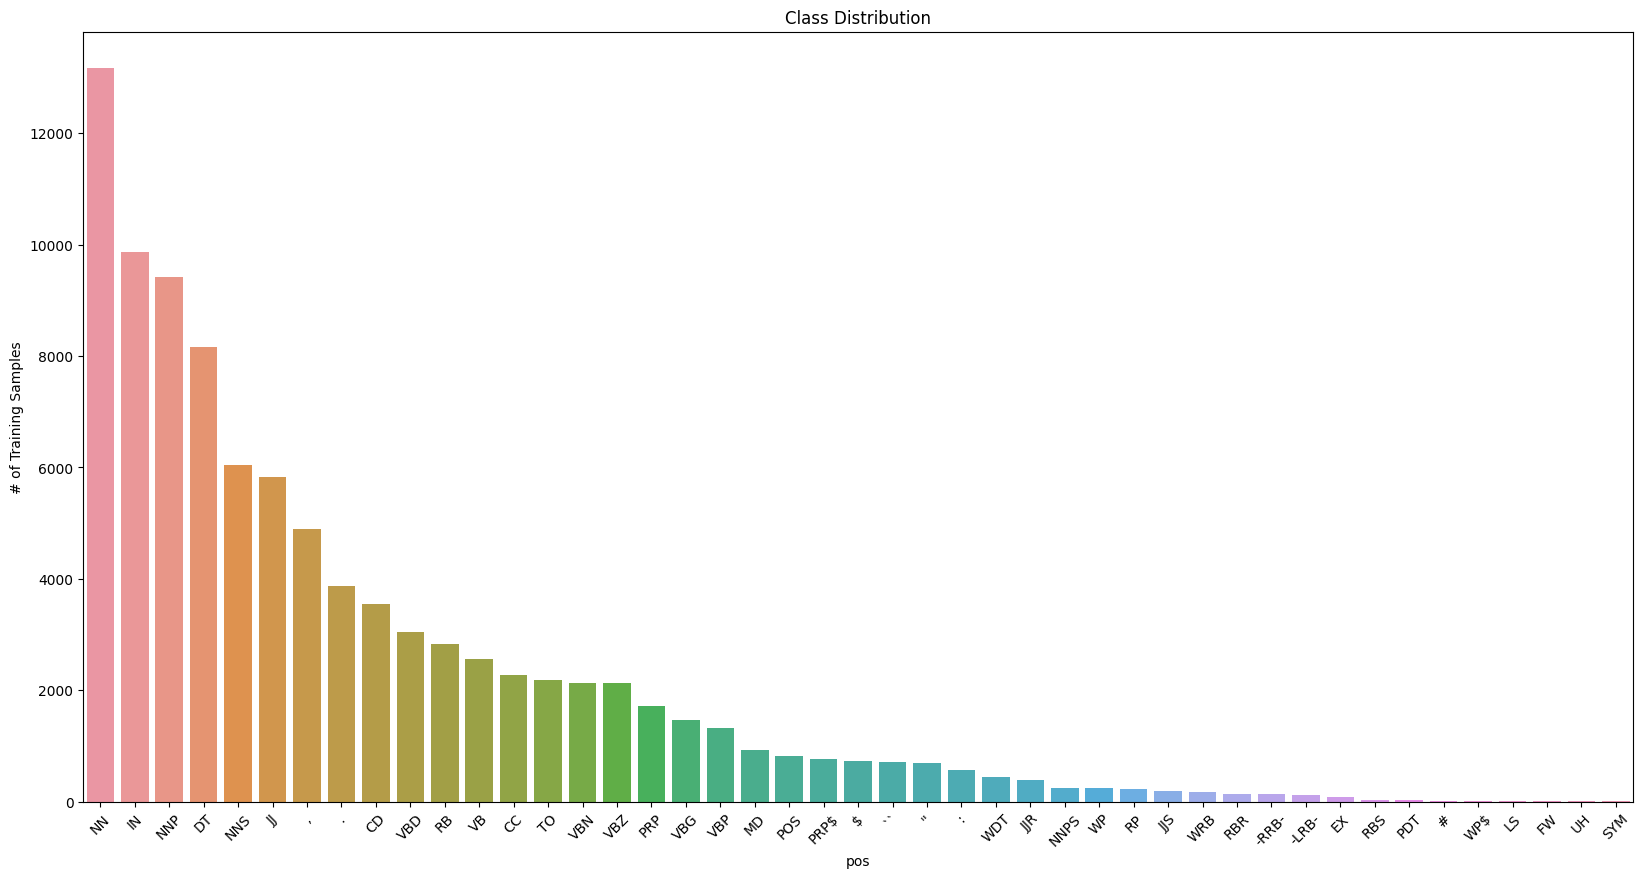

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(tags, x='pos', order=tags['pos'].value_counts().index, ax=ax);
plt.title('Class Distribution')
plt.ylabel('# of Training Samples')
plt.xticks(rotation = 45);

Classes are similarly distributed across the three splits

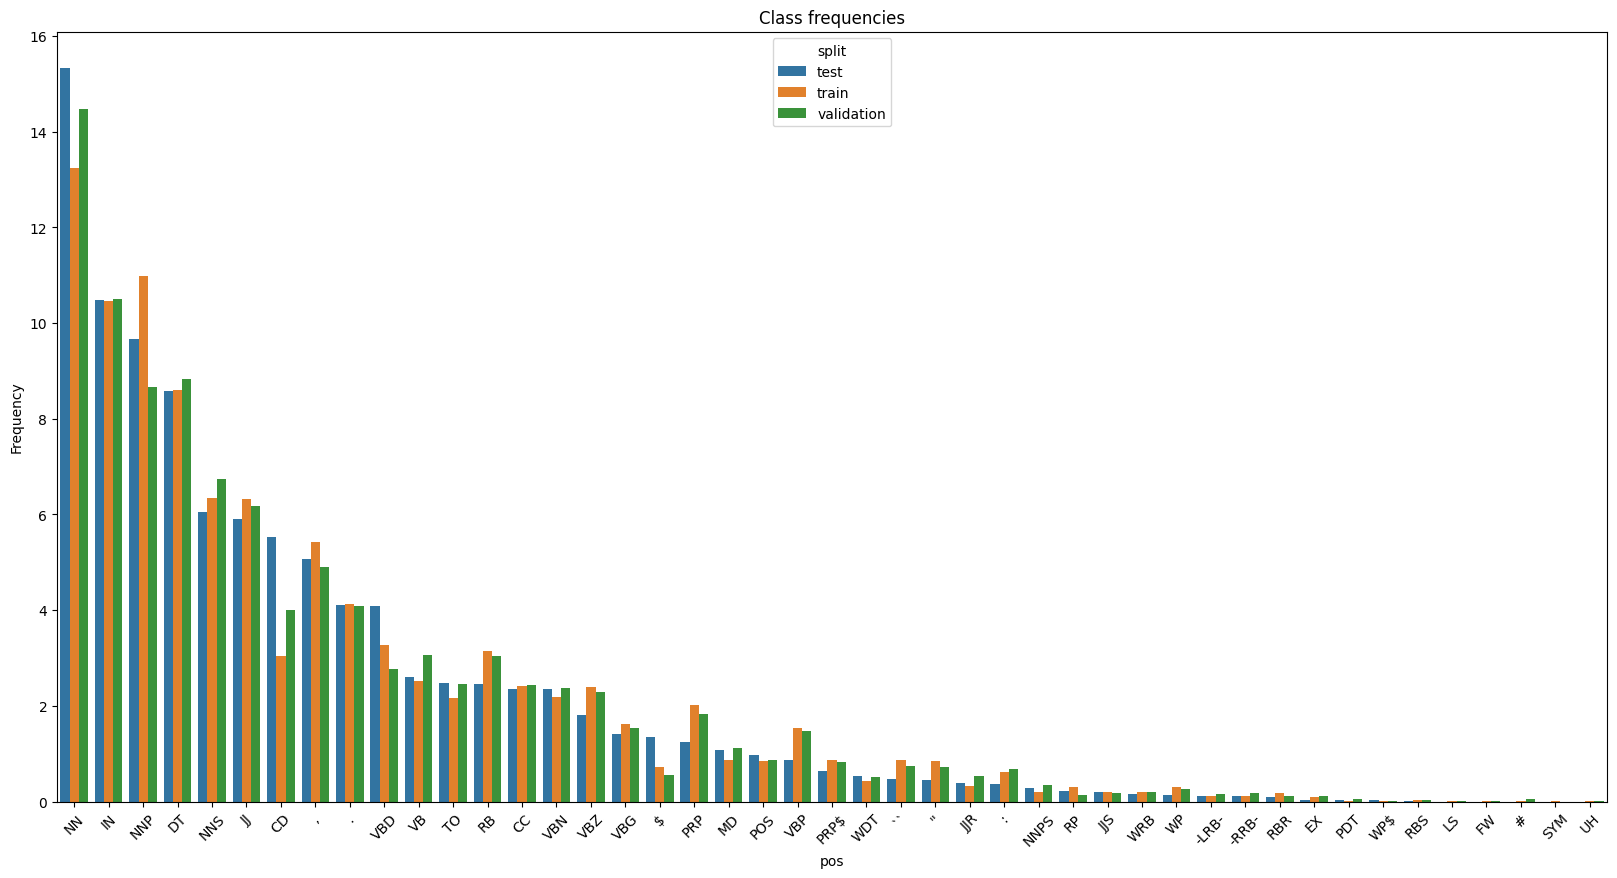

In [16]:
frequencies = (tags
    .groupby('split')['pos']
    .value_counts(normalize=True)
    .mul(100)
    .rename('frequency')
    .reset_index())

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(frequencies, x='pos', y='frequency', hue='split', ax=ax);
plt.title('Class frequencies')
plt.ylabel('Frequency')
plt.xticks(rotation = 45);

In [17]:
label_counts = pd.get_dummies(tags, columns=['pos'], prefix='', prefix_sep='').groupby('split').sum().reset_index()
cols = label_counts.columns[1:]
count_by_split = np.expand_dims(label_counts[cols].sum(axis=1), axis=1)
label_counts[cols] = label_counts[cols] / count_by_split
label_counts = label_counts.T.reset_index().rename(columns={'index':'pos', 0:'test', 1:'train', 2:'val'})[1:]
label_counts['punctuation'] = label_counts['pos'].isin(punctuation_tags)
label_counts.sort_values('test', ascending=False)

,pos,test,train,val,punctuation
20,NN,0.153297,0.132401,0.144726,False
14,IN,0.104857,0.10457,0.105025,False
21,NNP,0.096751,0.109849,0.086714,False
11,DT,0.08588,0.086071,0.088317,False
23,NNS,0.060534,0.063434,0.067409,False
15,JJ,0.059054,0.063181,0.0617,False
10,CD,0.055195,0.030387,0.040054,False
4,",",0.050627,0.054291,0.049001,True
7,.,0.041042,0.041368,0.040952,True
36,VBD,0.040785,0.032689,0.027611,False


In [18]:
label_counts.groupby('punctuation').sum().drop('pos', axis=1)

,test,train,val
punctuation,,,
False,0.879768,0.871569,0.879261
True,0.120232,0.128431,0.120739


Some classes are not present in the test set or in the validation set. In particular FW (foreign words), LS (list item markers), and UH (interjections)

In [19]:
cols = label_counts.columns[1:-1]
label_counts.loc[(label_counts[cols] == 0).any(axis=1)]

,pos,test,train,val,punctuation
1,#,0.0,0.000021,0.000481,True
13,FW,0.0,0.000042,0.000064,False
18,LS,0.0,0.000211,0.000096,False
32,SYM,0.0,0.000021,0.0,True
34,UH,0.0,0.000021,0.000064,False


## 2.3 Length Analysis

In [20]:
# We should not look at test data
data = df[df['split'] != 'test'].copy()
data['length'] = data['sentence'].str.split(words_separator).apply(len)

data['length'].describe()

count    3262.000000
mean       24.076947
std        12.229630
min         1.000000
25%        16.000000
50%        23.000000
75%        31.000000
max       249.000000
Name: length, dtype: float64

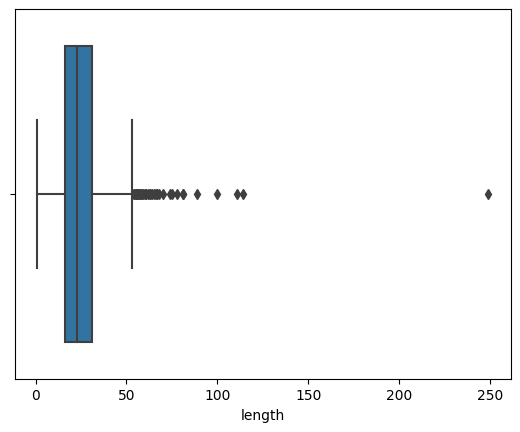

In [21]:
sns.boxplot(x=data['length']);

# 3. Data Preprocessing

*Text preprocessing*
We have lower case, upper case and capitalized words. Here we define three different strategies for preprocessing texts we will test:
- None: nothing is done
- lower: convert all words to the corresponding lower case string
- lower_up: convert only upper case words to the corresponding lower case string

The rationale of lower_up is that the upper case do not drive any information, therefore we make them lower to exploit embedding while preserving the case for capitalized words.

*Numbers preprocessing*
- None: nothing is done
- token: all numbers are replaced with a common token

See [preprocessing.py](preprocessing.py)

In [22]:
dataset = df.copy()
dataset['sentence'] = dataset['sentence'].apply(preprocess_text)
train_data, val_data, test_data = split_dataset(dataset)
dataset

,sentence,pos,file_id,split
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ...",1,train
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN .",1,train
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN...",2,train
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...,3,train
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ...",3,train
...,...,...,...,...
3909,They also said that more than a dozen presiden...,PRP RB VBD IN JJR IN DT NN NNS VBP VBN IN JJ N...,198,test
3910,Sen. Kennedy said in a separate statement that...,NNP NNP VBD IN DT JJ NN IN PRP VBZ NN TO VB DT...,198,test
3911,Trinity Industries Inc. said it reached a prel...,NNP NNPS NNP VBD PRP VBD DT JJ NN TO VB CD NN ...,199,test
3912,Terms were n't disclosed .,NNS VBD RB VBN .,199,test


# 4. Embedding

In [23]:
embedding_model = download_embedding_model(model_type=model_type, embedding_dimension=embedding_dimension)
embedding_model.save(embedding_model_file)

## 4.1 Embedding Analysis

In [24]:
embedding_words = set(embedding_model.key_to_index.keys())
n_embedding_words = len(embedding_words)
print("Total number of words into embeddings:", n_embedding_words)
lower = [word for word in embedding_words if str.islower(word)]
print("All lowercase?", len(lower) == n_embedding_words)

Total number of words into embeddings: 400000
All lowercase? False


In [25]:
embedding_contains_digits = set([word for word in embedding_words if has_digits(word)])
embedding_numbers = set([word for word in embedding_contains_digits if is_number(word)])
embedding_non_numbers = embedding_contains_digits.difference(embedding_numbers)
print("Total number of embedding words with digits:", len(embedding_contains_digits))
print(list(embedding_contains_digits)[:100])
print()
print("Total number of embedding numbers:", len(embedding_numbers))
print(list(embedding_numbers)[:100])
print()
print("Total number of embedding words with digits but that are not numbers:", len(embedding_non_numbers))
print(list(embedding_non_numbers)[:300])

Total number of embedding words with digits: 48970
['20-something', '12,000-acre', '22sec', 'm19', '51', '120-page', '8,510', 'mid-1940s', 'hsp60', '1.695', 'voodoo2', '1,740', 'kvant-2', '183,733', 't-60', '40-feet', '91-minute', '1.8250', 'g90', '10.44', 'σ1', '109.84', '20:13', '3,537', '3:59', '9.700', 'o-6', 'f7', 'b10m', '1,906', '4,502', '61-meter', 'zh00r', 'euro825', 'k-19', '3rd-placed', '6.68', 'of-3', '4,328', 'u-29', '1126', '3-6-3', '24.70', '6-for-6', '32-second', '1.5345', '1,530', '8-1', '75915', '56-seat', '38.3', '9500', '3,731', '144.3', '120.96', '20-22', '12-match', '30.23', '106-101', '2.69', '1,314', '50percent', '121.39', '2,170', '158.3', '135-140', '186.8', '956', '90.48', '42-13', 'sd1', 'film1', '44,600', '2,294', '76-14', '320-run', '24.46', '69.96', 'euro187', '3.61', '13-yard', '1.58', '1.194', '107.54', '210-seat', '996-0089', '1240s', '.525', '1978-79', 'unha-2', '7.28', '2,958', "'38", '31-19', '104-91', '109.2', '1290s', 'u-21s', '18.51', '136,000']


In [26]:
discard = set(lower).union(embedding_contains_digits)
remaining = embedding_words.difference(discard)
print('Total number of words that are neither lower case text nor words with digits:', len(remaining))
print(remaining)

Total number of words that are neither lower case text nor words with digits: 322
{'京兆', 'בית', '￥', '¼', '----------------------------', '행정동', '--', '-------------------------', 'में', '¢', 'མ', 'ಯ', '魏博', 'ର', 'ದ', 'الدين', '___', 'ابن', '李', 'ར', 'പ', '--------------------------------------------------', 'को', '⅛', 'ಶ', '!', '_______________________________', 'ס', '-----------', '““', '------', '‹', '------------------------------------------------', '⅓', '-------------------------------------------------------', 'احمد', 'خان', 'ද', '---------------------------------', '揚州', '_____________________________', "'", '昭義', '太守', 'في', '___________', '_____________________________________', 'י', '(', 'ക', '荊州', '_____________', '??', 'ក', '-------', '!!', '!?!', '¥', '„', '!?', 'ད', '人', ':', '~', 'ಟ', '“‘', '_________', 'علی', 'ව', '%', '_________________________________', '#', 'ത', '-----', '一', 'א', '-----------------', '----------------------------------------------------------------

## 4.2 Handling OOV
From the analysis above, we can see that all words in glove are lower case. Words that contains numbers are compositions of numbers-text. We can handle OOV in the following way:
- composed-words: we take as vector the mean of the single words vectors
- numbers: we consider one common embedding vector for all the numbers taken as the mean of all the numbers vectors
- capitalized words: we add to the corresponding lower case vector a common "capitalize" vector

See [embedding.py](embedding.py)
For time reasons, we compute the embeddings for the three dataset (separately), with the script mentioned above. Here, we show an example.

In [76]:
dataset, embedding_matrix = preprocess_and_create_embedding(df, embedding_model_file, text_strategy='lower')

100%|██████████| 400000/400000 [00:00<00:00, 779035.54it/s]


Adding training set terms ...
Number of OOV terms: 353


100%|██████████| 353/353 [00:04<00:00, 81.94it/s]


Number of new tokens: 353
New tokens: ['forest-products', '142.85', 'monchecourt', 'solaia', 'unfair-trade', 'sometimes-exhausting', 'home-market', '1.5755', 'industrial-production', 'sino-u.s.', 'gingl', 'pathlogy', '236.79', 'glenham', 'water-authority', 'automotive-lighting', 'twindam', '436.01', 'vinken', '70-a-share', '2,303,328', '-rrb-', 'school-district', 'ntg', 'anti-china', 'corton-charlemagne', 'tiphook', 'jerritts', 'circuit-breaker', 'index-related', 'auto-safety', 'life-insurance', '12,252', 'student-test', 'savers/investors', 'low-ball', 'computer-system-design', 'program-trading', '100,980', 'subskills', 'trading-company', 'test-prep', 'sell-offs', 'yeargin', 'war-rationed', 'nih-appointed', 'non-biodegradable', '4,393,237', 'macmillan/mcgraw', '69-point', '95,142', 'ac-130u', 'family-planning', 'three-sevenths', 'food-shop', 'school-board', 'bell-ringer', 'subskill', '374.19', '-rcb-', 'bald-faced', 'foreign-stock', '382-37', 'church-goers', '16.125', 'chinchon', 'comp

100%|██████████| 177/177 [00:02<00:00, 81.72it/s]


Number of new tokens: 177
New tokens: ['877,663', 'breakey', 'anti-program', 'price-support', 'express-buick', 'minicrash', 'egnuss', 'multi-crystal', '3,250,000', 'circuit-board', 'airline-related', '300-113', 'single-lot', '352.9', 'labor-backed', 'anku', 'mutchin', 'news-american', 'truth-in-lending', '7.272', '300-a-share', 'midwesco', 'arbitraging', 'arighi', 'lookee-loos', 'two-time-losers', '23,403', 'motor-home', 'less-than-brilliant', 'bank-backed', 'anti-deficiency', 'continuingly', 'food-industry', '14.', 'free-enterprise', 'potables', 'scypher', 'prevalance', 'lightning-fast', 'crystal-lattice', 'electrical-safety', '238,000-circulation', '35500.64', '7.458', 'melt-textured', 'freudtoy', 'dydee', 'stock-specialist', 'contingency-fee', 'pension-fund', '2163.2', 'triple-a-rated', 'stock-selection', 'anti-morning-sickness', 'seven-million-ton', 'clean-air', 'yttrium-containing', 'flim-flammery', 'executive-office', 'superdot', '1738.1', 'index-fund', 'insider-trading', 'corpor

100%|██████████| 127/127 [00:01<00:00, 83.60it/s]

Number of new tokens: 127
New tokens: ['computer-services', 'diloreto', 'waertsilae', 'derchin', '494.50', 'lentjes', '34.625', '11-month-old', 'minimum-wage', '3436.58', 'yoshihashi', '6,799', '566.54', 'intelogic', '263.07', '38.875', 'arbitrage-related', '2,050-passenger', '170,262', '630.9', '5,699', '120-a-share', 'txo', 'manmade-fiber', 'yet-to-be-formed', 'conn.based', 'cost-control', 'hadson', 'johnson-era', 'protein-1', 'interleukin-3', 'passenger-car', '967,809', 'g.m.b', '158,666', '0.0085', 'copper-rich', 'unicorp', '83,206', 'life-of-contract', 'heavy-truck', 'shareholder-rights', '319.75', 'lobsenz', '618.1', 'weapons-modernization', '434.4', 'more-advanced', 'prior-year', 'waymar', 'disputado', 'constitutional-law', '19-month-old', '300-day', 'pro-iranian', '188.84', '377.60', '87-store', 'reupke', 'noncompetitively', '237-seat', 'cents-a-unit', 'launch-vehicle', 'tete-a-tete', 'colorliner', '1.916', '18-a-share', '142.84', '100-megabyte', 'bankruptcy-law', 'louisiana-pa

# 5. Dataloader

In [81]:
train_data, val_data, test_data = split_dataset(dataset)

## 5.1 Tokenizer

In [77]:
class TextVectorization:
    def __init__(self, word_to_id: Dict[str, int], sep=' ') -> None:
        self.sep = sep

        words = list(word_to_id.keys())
        values = list(word_to_id.values())
        self.word_to_id = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(words, values),
            default_value=-1
        )
        self.id_to_word = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(values, words),
            default_value='[UNK]'
        )
        assert self.word_to_id.size() == len(word_to_id)
        assert self.id_to_word.size() == len(word_to_id)

    def vectorize(self, text) -> tf.RaggedTensor:
        tokens = self.tokenize(text)
        return self.tokens_to_ids(tokens)
    
    def invert(self, ids: tf.RaggedTensor) -> tf.RaggedTensor:
        tokens = self.ids_to_tokens(ids)
        texts = tf.strings.reduce_join(tokens, separator=self.sep, axis=-1)
        return texts

    def tokenize(self, text) -> tf.RaggedTensor:
        tokens = tf.strings.split(text, sep=self.sep)
        return tokens

    def tokens_to_ids(self, tokens: tf.RaggedTensor | list | tuple | np.ndarray) -> tf.RaggedTensor:        
        if isinstance(tokens, (list, tuple, np.ndarray)):
            tokens = tf.ragged.constant(tokens)
        return tf.ragged.map_flat_values(self.word_to_id.lookup, tokens)
    
    def ids_to_tokens(self, ids: tf.RaggedTensor) -> tf.RaggedTensor:        
        ids = tf.cast(ids, tf.int32)
        tokens = tf.ragged.map_flat_values(self.id_to_word.lookup, ids)
        return tokens

In [78]:
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
label_vocabulary = {tag: id for tag, id in zip(tags, range(1, n_tags + 1))}
label_vocabulary[''] = 0
assert len(label_vocabulary) == n_tags + 1

print(label_vocabulary)

{'RBR': 1, ',': 2, "''": 3, 'VBP': 4, 'JJS': 5, 'VBD': 6, 'CD': 7, 'FW': 8, 'TO': 9, 'WDT': 10, 'POS': 11, 'NNP': 12, 'NNPS': 13, 'VB': 14, 'NN': 15, ':': 16, 'MD': 17, 'DT': 18, 'WP': 19, 'UH': 20, 'PRP': 21, 'EX': 22, 'NNS': 23, 'JJR': 24, 'SYM': 25, '-LRB-': 26, '$': 27, '-RRB-': 28, 'PDT': 29, '.': 30, 'IN': 31, 'WRB': 32, 'RBS': 33, 'PRP$': 34, '``': 35, 'VBZ': 36, 'RB': 37, 'WP$': 38, 'LS': 39, '#': 40, 'VBN': 41, 'CC': 42, 'JJ': 43, 'VBG': 44, 'RP': 45, '': 0}


In [82]:
tokenizer = TextVectorization(embedding_matrix.vocabulary())
label_tokenizer = TextVectorization(label_vocabulary)

assert tf.reduce_all(tokenizer.invert(tokenizer.vectorize(train_data.sentence.values)) == tf.constant(train_data.sentence.values))
assert tf.reduce_all(label_tokenizer.invert(label_tokenizer.vectorize(train_data.pos.values)) == tf.constant(train_data.pos.values))

## 5.2 Dataloader

In [83]:
def one_hot(inputs: tf.Tensor, num_classes, ignore_padding=False):
  if ignore_padding:
    # supposing padding=0 -> padding=-1 -> padding = [0,...,0]
    inputs -= 1
  else:
    num_classes += 1
  return tf.one_hot(inputs, depth=num_classes)

def one_hot_to_ids(one_hot: tf.Tensor, ignore_padding=False) -> tf.Tensor:
    ids = tf.argmax(one_hot, axis=-1, output_type=tf.int32)
    assert one_hot.shape[:2] == ids.shape
    
    if ignore_padding:
      ids += 1

    return ids

def pad(sentences: tf.RaggedTensor, tags: tf.RaggedTensor):
  sentences = sentences.to_tensor(default_value=0)
  tags = tags.to_tensor(default_value=0)

  return sentences, tags

# workaround to avoid lambda functions
def one_hot_encode_labels(sentences: tf.Tensor, tags: tf.Tensor, num_classes, ignore_padding):
  return sentences, one_hot(tags, num_classes, ignore_padding)

def create_dataloader(
  dataset: pd.DataFrame,
  tokenizer: TextVectorization,
  label_tokenizer: TextVectorization,
  batch_size=32,
  multi_label=False, training=True):

  sentences = tokenizer.vectorize(dataset['sentence'])
  labels = label_tokenizer.vectorize(dataset['pos'])

  dataset = (
      tf.data.Dataset.from_tensor_slices((sentences, labels))
  )
  
  if training:
    dataset = dataset.shuffle(buffer_size=2048)

  # workaround to avoid lambda functions
  encode_labels = functools.partial(one_hot_encode_labels, num_classes=n_tags, ignore_padding=multi_label)

  dataset = (
      dataset
      .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
      .map(pad, num_parallel_calls=tf.data.AUTOTUNE)
      .map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
      )
  
  return dataset

dataloader = create_dataloader(train_data, tokenizer, label_tokenizer)

In [84]:
batched_text, batched_tags = next(dataloader.take(1).as_numpy_iterator())
text = batched_text[0]
tags = batched_tags[0]

print('Encoded text:', text.shape)
print(text)
print('One hot encoded tags:', tags.shape)
print(tags)

Encoded text: (54,)
[35375   521   120    37   304     5   873     8   717    13   120    37
   489 13887     3    28     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
One hot encoded tags: (54, 46)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


# 6. Architectures

In [85]:
class TimeDistributedDense(ks.layers.TimeDistributed):
  def __init__(self, *dense_args, **dense_kwargs) -> None:
        super().__init__(ks.layers.Dense(*dense_args, **dense_kwargs))        

class ModelFactory():
  def __init__(self, embedding_weights, n_tags):
    self.embedding_weights=embedding_weights
    self.n_tags=n_tags
  
  def create_model(self,
              rnn_units=128,
              use_gru=False, 
              additional_lstm=False,
              additional_dense=False,
              additional_dense_units=10,
              dropout=0.0,
              multi_label=False,
              name = None):
    """
    Parameters
      ----------
      rnn_units: int
          The hidden state's dimension of the RNNs
      use_gru: bool
          If True, use a BiGRU layer instead of the BiLSTM
      additional_lstm: bool
          If True, use an additional BiLSTM layer right after the default one
      additional_dense: bool
          If True, adds a FC layer before the classifier
      additional_dense_units: int
        The hidden state's dimension of the additional dense layers
      dropout: float
          Define the drop rate of the Dropout layers. By default the dropout is disabled
      multi_label: bool
        If True, the problem is considered to be multi label and the last layer uses sigmoid instead of softmax
      name: str
          The name of the model          
      Returns
      -------
      tensorflow.keras.models.Model
          The POS-tagging model          
    """
    
    inputs = ks.layers.Input(shape=(None, ))
    x = ks.layers.Embedding(*self.embedding_weights.shape, weights=[self.embedding_weights],
                            mask_zero=True, trainable=False)(inputs)

    if use_gru:
      assert not additional_lstm and not additional_dense, "use_gru cannot be used together with additional_lstm or additional_dense"
      rnn = ks.layers.GRU(units=rnn_units, return_sequences=True, dropout=dropout, name='gru')
    else:
      rnn = ks.layers.LSTM(units=rnn_units, return_sequences=True, dropout=dropout, name='lstm')
    x = ks.layers.Bidirectional(rnn, name=f'bidirectional_{rnn.name}')(x)

    if additional_lstm:
      assert not use_gru and not additional_dense, "additional_lstm cannot be used together with use_gru or additional_dense"
      rnn = ks.layers.LSTM(units=rnn_units, return_sequences=True, dropout=dropout)
      x = ks.layers.Bidirectional(rnn, name='bidirectional_lstm2')(x)

    if additional_dense:
      assert not use_gru and not additional_lstm, "additional_dense cannot be used together with use_gru or additional_lstm"
      assert additional_dense_units > 0
      x = TimeDistributedDense(additional_dense_units, activation='relu')(x)
      if dropout:
        x = ks.layers.Dropout(dropout)(x)

    if multi_label:        
      x = TimeDistributedDense(self.n_tags, activation='sigmoid', dtype=np.float32)(x)
    else:
      x = TimeDistributedDense(self.n_tags+1, activation='softmax', dtype=np.float32)(x)

    return ks.models.Model(inputs, x, name=name)

In [87]:
models = {}
models['base'] = {
    'name': 'base',
    'use_gru': False,
    'additional_lstm': False,
    'additional_dense': False,
}
models['gru'] = {
    'name': 'gru',
    'use_gru': True,
    'additional_lstm': False,
    'additional_dense': False,
}
models['additional_lstm'] = {
    'name': 'additional_lstm',
    'use_gru': False,
    'additional_lstm': True,
    'additional_dense': False,
}
models['additional_dense'] = {
    'name': 'additional_dense',
    'use_gru': False,
    'additional_lstm': False,
    'additional_dense': True,
}

model_factory = ModelFactory(embedding_matrix.vectors(), n_tags=n_tags)
for model_name, architecture in models.items():
  model = model_factory.create_model(**architecture)
  model.summary()
  print()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          20032900  
                                                                 
 bidirectional_lstm (Bidirec  (None, None, 256)        183296    
 tional)                                                         
                                                                 
 time_distributed_dense (Tim  (None, None, 46)         11822     
 eDistributedDense)                                              
                                                                 
Total params: 20,228,018
Trainable params: 195,118
Non-trainable params: 20,032,900
_________________________________________________________________

Model: "gru"
______________________________

# 6. Training

Here, we define training methods and run them on the baseline model.

In [89]:
def show_history(history: ks.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
    plt.show()

In [90]:
def train_model(model: ks.Model,
                train_data: tf.data.Dataset,
                val_data: tf.data.Dataset,
                training_info: Dict,
                show=True):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param train_data: training data
    :param val_data: validation data
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print(f"Start training! \nParameters: {training_info}")
    history = model.fit(x=train_data,
                        validation_data=val_data,
                        **training_info)
    print("Training completed!")

    if show:
        print("Showing history...")
        show_history(history)

    return history

Start training! 
Parameters: {'verbose': 1, 'epochs': 3, 'batch_size': 1024}
Epoch 1/3
2/2 [==============================] - 14s 5s/step - loss: 3.8131 - categorical_accuracy: 0.0150 - val_loss: 3.6357 - val_categorical_accuracy: 0.1192
Epoch 2/3
2/2 [==============================] - 9s 3s/step - loss: 3.5891 - categorical_accuracy: 0.1207 - val_loss: 3.4309 - val_categorical_accuracy: 0.1536
Epoch 3/3
2/2 [==============================] - 9s 4s/step - loss: 3.3881 - categorical_accuracy: 0.1454 - val_loss: 3.2471 - val_categorical_accuracy: 0.1584
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


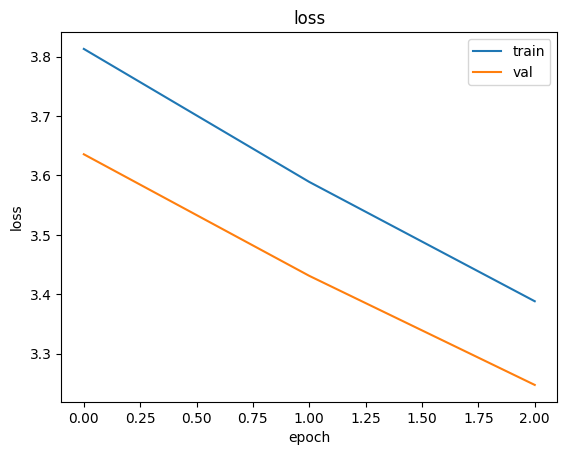

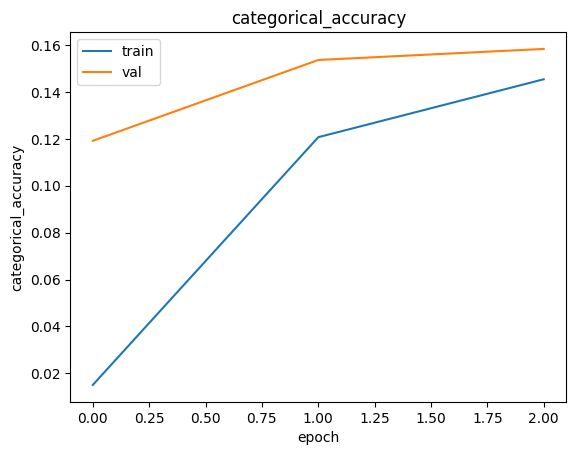

In [91]:
compile_info = {
    'optimizer': ks.optimizers.Adam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics': ['categorical_accuracy'],
}
model = model_factory.create_model(**models['base'])
model.compile(**compile_info)

training_info = {
    'verbose': 1,
    'epochs': 3,
    'batch_size': 1024,
}

train_dataloader = create_dataloader(train_data, tokenizer, label_tokenizer, batch_size=training_info['batch_size'])
val_dataloader = create_dataloader(val_data, tokenizer, label_tokenizer, batch_size=training_info['batch_size'], training=False)
history = train_model(model=model, train_data=train_dataloader, val_data=val_dataloader, training_info=training_info)

# 7. Evaluation

In this section, we define evaluation functions. In particular, we create functions to mask padding and punctuation tags, then we define a class that automatically evaluate the dataset according to the metrics provided.

In [92]:
def compute_blacklist_mask(y_true: tf.Tensor, black_list: Iterable[str]) -> tf.Tensor:
  return ~tf_in(y_true, black_list)

class PosEvaluator():
  def __init__(self, label_tokenizer:TextVectorization, banned_tags:Iterable[str], multilabel=False) -> None:
    self.banned_tags = label_tokenizer.tokens_to_ids(banned_tags).numpy()
    self.multilabel = multilabel  

  def compute_padding_mask(self, y_true: tf.Tensor) -> tf.Tensor:
    return y_true != 0

  def compute_mask(self, y_true: tf.Tensor, remove_banned_tags=True) -> tf.Tensor:
    mask = padding_mask = self.compute_padding_mask(y_true)
    if remove_banned_tags:
      blacklist_mask = compute_blacklist_mask(y_true, self.banned_tags)
      mask = tf.logical_and(padding_mask, blacklist_mask)
    return mask

  def apply_mask(self, y_pred: tf.Tensor, y_true: tf.Tensor, remove_banned_tags=True) -> Tuple[tf.RaggedTensor, tf.RaggedTensor]:
    assert y_pred.shape == y_true.shape
    mask = self.compute_mask(y_true, remove_banned_tags=remove_banned_tags)

    masked_pred = tf.ragged.boolean_mask(y_pred, mask)
    masked_true = tf.ragged.boolean_mask(y_true, mask)

    return masked_pred, masked_true

  def predict(self, model: ks.Model, data:tf.data.Dataset) -> Tuple[tf.RaggedTensor, tf.RaggedTensor]:
    y_pred = model.predict(data, verbose=True).to_tensor(default_value=0)
    y_true = tf.ragged.stack([y for x, y in data.unbatch()]).to_tensor(default_value=0)
    assert y_pred.shape == y_true.shape
    
    y_pred = one_hot_to_ids(y_pred, ignore_padding=self.multilabel)
    y_true = one_hot_to_ids(y_true, ignore_padding=self.multilabel)
    
    return self.apply_mask(y_pred, y_true, remove_banned_tags=False)

  def evaluate_predictions(self,
    y_pred: tf.Tensor,
    y_true: tf.Tensor,
    metrics: Dict[str, Callable]) -> Tuple[tf.Tensor, tf.Tensor, Dict[str, object]]:
    """
      Evaluates given model predictions on a list of metric functions

      :param y_pred: model predictions as sequence of integers
      :param y_true: ground-truth labels as sequence of integers
      :param metrics: dictionary of (metric_name, metric_fn)

      :return
        - filtered prediction labels
        - filtered true lables
        - metric_info: dictionary containing metric values for each input metric
      """
    assert y_pred.shape == y_true.shape

    print(f"Evaluating predictions! Total samples: {y_pred.shape[0]}")

    masked_pred, masked_true = self.apply_mask(y_pred, y_true)
    masked_pred = np.array(tf.reshape(masked_pred, -1), dtype=np.int32)
    masked_true = np.array(tf.reshape(masked_true, -1), dtype=np.int32)

    metric_info = {}
    for metric_name, metric in metrics.items():
        metric_value = metric(y_pred=masked_pred, y_true=masked_true)
        metric_info[metric_name] = metric_value

    return masked_pred, masked_true, metric_info

  def evaluate(self, model: ks.Model, data:tf.data.Dataset, metrics:Dict[str, Callable]) -> Tuple[tf.Tensor, tf.Tensor, Dict[str, object]]:
    y_pred, y_true = self.predict(model, data)    
    return self.evaluate_predictions(y_pred, y_true, metrics)

def _test_evaluate():
  print('Testing evaluation functions ...')
  banned_tags = ['NN', 'CC', 'JJ']

  y = [['NN', 'RBR', 'CC', '', ''], ['JJ', 'JJ', 'IN', 'WDT', '']]
  y = label_tokenizer.tokens_to_ids(y)  

  evaluator = PosEvaluator(label_tokenizer, banned_tags)

  padding_mask = evaluator.compute_padding_mask(y)
  assert padding_mask.shape == y.shape, f'{padding_mask.shape} != {y.shape}'
  assert tf.reduce_all(padding_mask == tf.constant([[True, True, True, False, False], [True, True, True, True, False]]))

  blacklist_mask = compute_blacklist_mask(y, label_tokenizer.tokens_to_ids(banned_tags).numpy())
  assert blacklist_mask.shape == y.shape, f'{blacklist_mask.shape} != {y.shape}'
  assert tf.reduce_all(blacklist_mask == tf.constant([[False, True, False, True, True], [False, False, True, True, True]]))

  mask = evaluator.compute_mask(y)
  assert mask.shape == y.shape, f'{mask.shape} != {y.shape}'
  assert tf.reduce_all(mask == tf.constant([[False, True, False, False, False], [False, False, True, True, False]]))

  y_true = [['NN', 'RBR', 'CC', '', ''], ['JJ', 'JJ', 'IN', 'WDT', '']]
  y_pred = [['NN', 'WDT', 'CC', '', ''], ['JJ', 'CC', 'IN', 'WDT', '']]
  y_true = label_tokenizer.tokens_to_ids(y_true).to_tensor(0)
  y_pred = label_tokenizer.tokens_to_ids(y_pred).to_tensor(0)
  # assert y_true.shape == y_pred.shape
  # y_true = one_hot(y_true, num_classes=50)
  # y_pred = one_hot(y_pred, num_classes=50)
  assert y_true.shape == y_pred.shape

  pred, true = evaluator.apply_mask(y_pred, y_true)
  assert pred.shape == true.shape
  assert tf.reduce_all(pred == label_tokenizer.tokens_to_ids([['WDT'], ['IN', 'WDT']]))
  assert tf.reduce_all(true == label_tokenizer.tokens_to_ids([['RBR'], ['IN', 'WDT']]))
  
  print('Test successfully completed!')

_test_evaluate()

Testing evaluation functions ...
Test successfully completed!


In [93]:
evaluator = PosEvaluator(label_tokenizer=label_tokenizer, banned_tags=punctuation_tags)

test_dataloader = create_dataloader(test_data, tokenizer, label_tokenizer, training=False)
y_pred, y_true = evaluator.predict(model=model, data=test_dataloader)

assert y_pred.shape[0] == len(test_data)
max_length = test_data['sentence'].str.split(words_separator).apply(len).max()
assert y_pred.to_tensor(0).shape[1] == max_length

print(y_pred.shape)
print(y_pred[:10])

21/21 [==============================] - 2s 12ms/step
(652, None)
<tf.RaggedTensor [[15, 15, 15, 15, 15, 15, 15, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
  15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
  15, 15, 15, 15]                                                        ,
 [31, 15, 15, 31, 31, 31, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
  15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]                        ,
 [31, 15, 31, 31, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
  15]                                                                    ,
 [31, 15, 31, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
  15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]        ,
 [15, 15, 12, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
  15, 15]                                                                ,
 [31, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
  15, 15, 15, 15, 15, 15

In [94]:
valid_labels = list(set(label_vocabulary.keys()).difference(punctuation_tags + ['']))
encoded_valid_labels = list(label_tokenizer.tokens_to_ids(valid_labels).numpy())
macro_f1 = functools.partial(f1_score, zero_division=0, average='macro', labels=encoded_valid_labels)

metrics = {
    'macro_f1': macro_f1,
    'classification report': functools.partial(classification_report, zero_division=0, labels=encoded_valid_labels, target_names=valid_labels),
}

y_pred, y_true, metric_info = evaluator.evaluate_predictions(
    y_pred=y_pred, y_true=y_true,
    metrics=metrics)

print(y_pred.shape)

assert y_pred.shape == y_true.shape
n_non_banned = np.count_nonzero(~test_data['pos'].str.split(words_separator).explode().isin(punctuation_tags))
assert y_pred.shape[0] == n_non_banned

for metric_name, metric, in metric_info.items():
    print(metric_name)
    print(metric)

Evaluating predictions! Total samples: 652
(13676,)
macro_f1
0.01570799420082327
classification report
              precision    recall  f1-score   support

         RBR       0.00      0.00      0.00        15
         JJS       0.00      0.00      0.00        31
         VBD       0.00      0.00      0.00       634
          CD       0.00      0.00      0.00       858
          FW       0.00      0.00      0.00         0
          TO       0.00      0.00      0.00       386
         WDT       0.00      0.00      0.00        84
         POS       0.00      0.00      0.00       152
         NNP       0.72      0.06      0.12      1504
        NNPS       0.00      0.00      0.00        44
          VB       0.00      0.00      0.00       403
          NN       0.18      0.97      0.31      2383
          MD       0.00      0.00      0.00       167
          DT       0.07      0.00      0.00      1335
          WP       0.00      0.00      0.00        20
          UH       0.00      0.0

# 8. Experiment

In this section we want to:
1. find the best hyper parameters on the baseline model.
2. find the best preprocessing and embedding strategies on the baseline model.
3. find the best hyperparameters for different architectures defined above and choose the best two models. 

## 8.1 Tune baseline model 

- The evaluation of the model is done on the validation set by using macro F1.
- Hyperparameter tuning is done by using the Bayesian Optimization from keras_tuner library. 

In [104]:
class MyHyperModel(keras_tuner.HyperModel):
  def __init__(self, model_factory: ModelFactory, architectures: Dict[str, Dict], compile_info: dict, evaluation_fn=None) -> None:
    super().__init__()
    self.model_factory = model_factory
    self.architectures = architectures
    self.compile_info = compile_info
    self.evaluation_fn = evaluation_fn

  def build(self, hp: keras_tuner.HyperParameters) -> ks.Model:
    architecture = hp.Choice('architecture', list(models.keys()))
    hyperparameters={
        'rnn_units': hp.Int('rnn_units', min_value=32, max_value=512, step=32)
    }
    with hp.conditional_scope('architecture', 'additional_dense'):
      if architecture == 'additional_dense':
        hyperparameters['additional_dense_units'] = hp.Int('additional_dense_units', min_value=2, max_value=100, step=2)
      
    model.compile(**self.compile_info)

    return model

  # If the fit method returns an objective function instead of the history, this will be minimized.
  # We exploit it to compute f1 on the whole validation dataset.
  def fit(self, hp: keras_tuner.HyperParameters, model: ks.Model, validation_data, *fit_args, **fit_kwargs):
    history = model.fit(*fit_args, validation_data=validation_data, **fit_kwargs)
    if self.evaluation_fn:
      return self.evaluation_fn(model, validation_data)
    else:
      return history

def evaluate(model:ks.Model, validation_data: tf.data.Dataset, evaluator: PosEvaluator):
    _,_,results = evaluator.evaluate(model, validation_data, {'macro_f1': macro_f1})
    return -1 * results['macro_f1'] # tuner minimize the objective function

def get_tuner(hypermodel: keras_tuner.HyperModel, model_name, trials=10, **kwargs):
  return keras_tuner.BayesianOptimization(
    hypermodel=hypermodel,
    # No objective to specify.
    # Objective is the return value of `HyperModel.fit()`.
    max_trials=trials,
    num_initial_points=None,
    directory = "tuning",
    project_name=model_name,
    overwrite=True,
    seed=current_seed(),
    **kwargs
    )

For the baseline model, the only hyperparameter we need to tune is:
- rnn_units: dimension of the hidden state of the rnn layers [32:512:32]

In [105]:
compile_info = {
    'optimizer': ks.optimizers.Adam(learning_rate=1e-3), # we do not need to tune it now
    'loss': 'categorical_crossentropy',
}

dataset, embedding_matrix = preprocess_and_load_embedding(df, text_strategy='lower', number_strategy=None, composed_words=False)
tokenizer = TextVectorization(embedding_matrix.vocabulary(), sep=words_separator)

train_data, val_data, test_data = split_dataset(dataset)
train_dataloader = create_dataloader(train_data, tokenizer, label_tokenizer, batch_size=512)
val_dataloader = create_dataloader(val_data, tokenizer, label_tokenizer, batch_size=512, training=False)

model_factory = ModelFactory(embedding_matrix.vectors(), n_tags=n_tags)
evaluator = PosEvaluator(label_tokenizer, banned_tags=punctuation_tags, multilabel=False)
evaluation_fn = functools.partial(evaluate, evaluator=evaluator)

baseline = {'base': models['base']} # consider only the baseline architecture
hypermodel = MyHyperModel(model_factory, architectures=baseline, compile_info=compile_info, evaluation_fn=evaluation_fn)

WARNING:tensorflow:5 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000011E2BF989D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

In [107]:
tuner = get_tuner(hypermodel, 'baseline', trials=2)
tuner.search_space_summary() # additional_dense_units will never be tuned
tuner.search(x=train_dataloader, validation_data=val_dataloader, epochs=2)

Trial 2 Complete [00h 00m 34s]
default_objective: -0.1302447210415921

Best default_objective So Far: -0.1302447210415921
Total elapsed time: 00h 01m 07s
INFO:tensorflow:Oracle triggered exit


## 8.2 Tune preprocessing and embedding strategies

Since words in Glove are lower case, it doesn't make sense not to lowerize texts at all. Therefore, we compare the two text strategies first

embedding_strategies={
  'text_strategy': [None, 'lower', 'lower_up'],
  'number_strategy': [None, 'token'],
  'composed_words': [False, True],
}

## 8.3 Model Selection

In [227]:
print('Banned tags with support > 0')
tags = np.unique(y_pred[tf_in(y_pred, evaluator.banned_tags)])
tags = label_tokenizer.ids_to_tokens(tags)
print(tags)

Banned tags with support > 0
tf.Tensor([b':' b',' b'``' b'.'], shape=(4,), dtype=string)


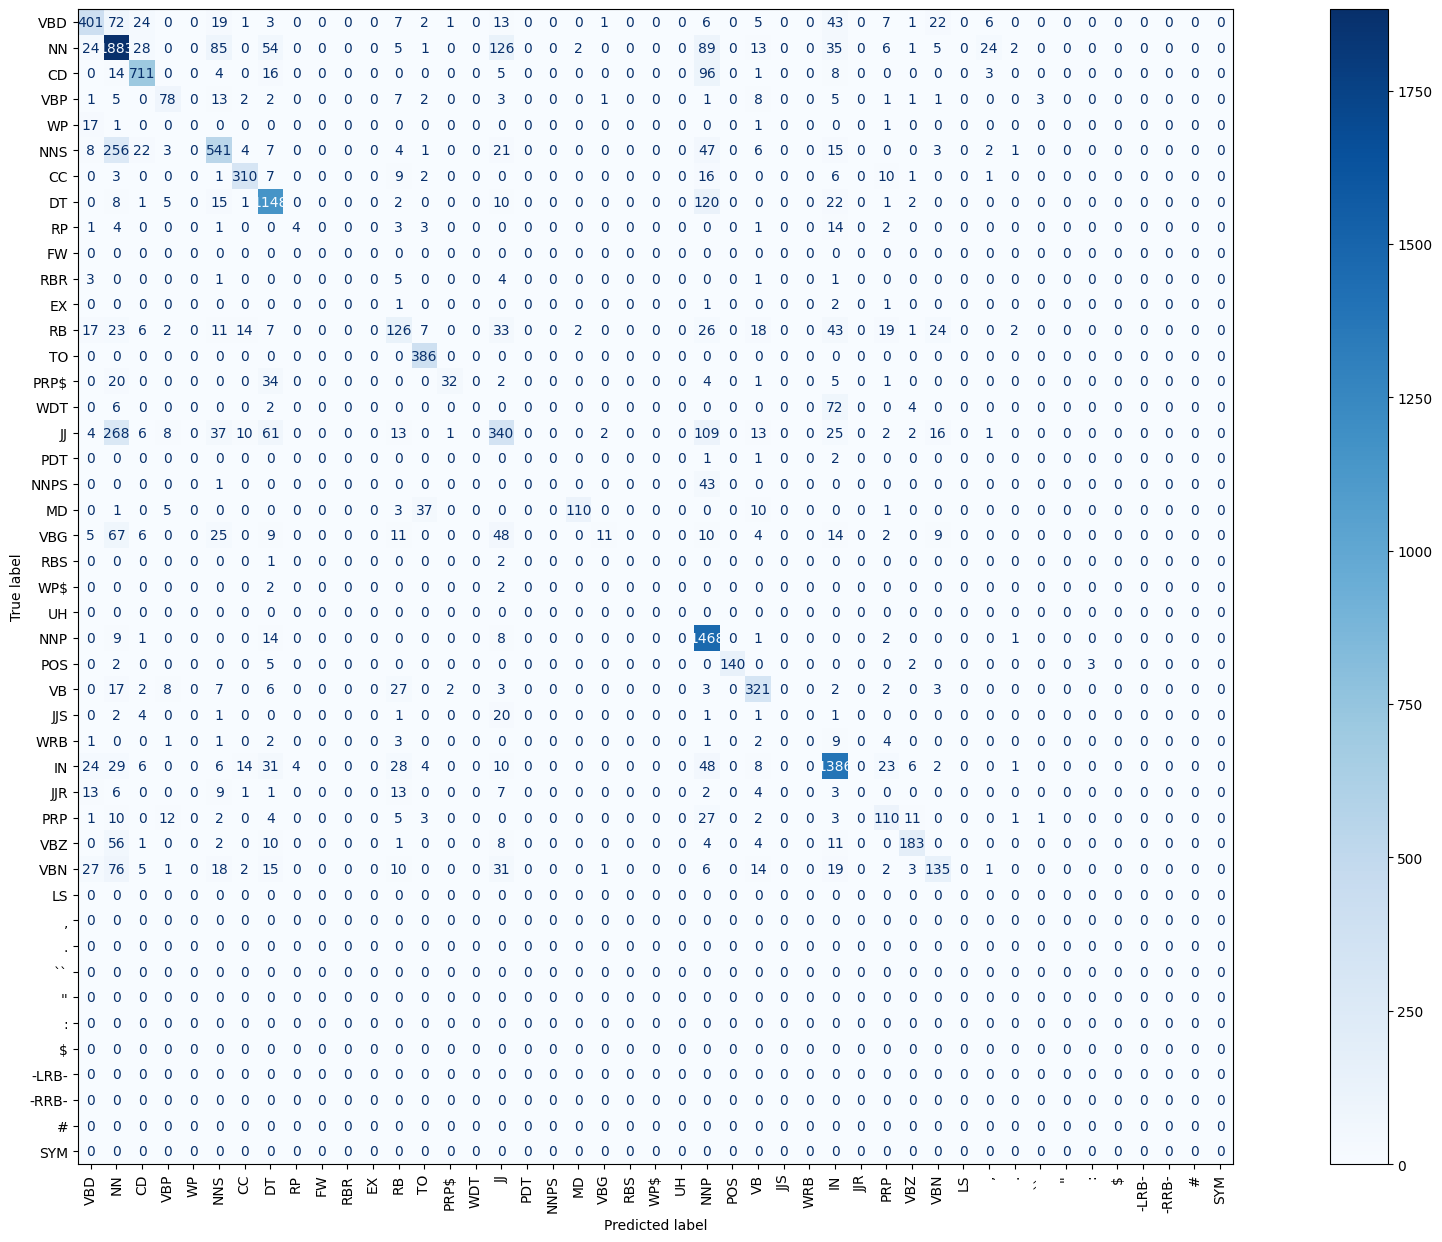

In [229]:
labels = valid_labels + punctuation_tags
encoded_labels = list(label_tokenizer.tokens_to_ids(labels))

fig, ax = plt.subplots(figsize=(25,15))
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=encoded_labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues', xticks_rotation='vertical', ax=ax);

# 2 Model Selection and Hypeparameters Tuning

In [267]:
trials = 2
epochs = 1
tuner = keras_tuner.BayesianOptimization(
    hypermodel=hypermodel,
    # No objective to specify.
    # Objective is the return value of `HyperModel.fit()`.
    max_trials=trials,
    num_initial_points=None,
    project_name="tuning",
    overwrite=True,
    seed=current_seed()
)
tuner.search_space_summary()
tuner.search(x=train_dataloader, validation_data=val_dataloader, epochs=epochs)

Trial 2 Complete [00h 00m 26s]
default_objective: -0.026224849019060397

Best default_objective So Far: -0.026224849019060397
Total elapsed time: 00h 00m 52s
INFO:tensorflow:Oracle triggered exit


In [268]:
tuner.results_summary()

Results summary
Results in .\tuning
Showing 10 best trials
Trial summary
Hyperparameters:
architecture: additional_dense
rnn_units: 160
additional_dense_units: 90
Score: -0.026224849019060397
Trial summary
Hyperparameters:
architecture: base
rnn_units: 64
Score: -0.02600628543892498


In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))
model.fit(x=x_all, y=y_all, epochs=1)

TypeError: ignored